# Question 4
### Reproduce Figure 1 in the paper. When doing that, try to slice data using `xarray` in the most clear and reproducible way (for example, don't use indices to access data objects like we did in the example above).

In [17]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import fsspec

import xarray as xr
xr.set_options(display_style="html")  # display dataset nicely

import warnings
warnings.simplefilter("ignore")  # filter some warning messages

# code features from https://scitools.org.uk/cartopy/docs/v0.14/matplotlib/feature_interface.html
crs = ccrs.PlateCarree()  # set projection

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

from pathlib import Path

# Small style adjustments for more readable plots
plt.style.use("seaborn-whitegrid")
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["font.size"] = 14

In [3]:
from matplotlib import cm
import matplotlib.colors
# Create custom color mapping to match the paper
cmap_custom = matplotlib.colors.LinearSegmentedColormap.from_list("", ["darkblue","blue","cyan","white","yellow","red","darkred"])

## Data processing

In [6]:
# Import data
ds = xr.open_dataset("~/shared/climate-data/ds_hw.nc")

In [7]:
# According to the paper, anomalies are calculated using the mean across time
# Take the average of the temperature per month from 2002 - 2012
anomaly_baseline = ds.analysed_sst.sel(time=slice('2002-06-01T09:00:00.000000000','2013-01-01T09:00:00.000000000'))
anomaly_baseline_mean = anomaly_baseline.groupby(anomaly_baseline.time.dt.month).mean("time")

In [8]:
# Now calculate the anomalies using the baseline mean per lat & long & month
# First try 2014
ds_2014 = ds.analysed_sst.sel(time=slice('2014-01-01T09:00:00.000000000','2014-12-31T09:00:00.000000000'))
ds_2015 = ds.analysed_sst.sel(time=slice('2015-01-01T09:00:00.000000000','2015-12-31T09:00:00.000000000'))
ds_2016 = ds.analysed_sst.sel(time=slice('2016-01-01T09:00:00.000000000','2016-12-31T09:00:00.000000000'))

In [9]:
anomalies_2014 = ds_2014.groupby(ds_2014.time.dt.month).mean("time") - anomaly_baseline_mean
anomalies_2015 = ds_2015.groupby(ds_2015.time.dt.month).mean("time") - anomaly_baseline_mean
anomalies_2016 = ds_2016.groupby(ds_2016.time.dt.month).mean("time") - anomaly_baseline_mean

In [10]:
# Make any value that lies within +- 1 delta SST SD to be 0
# Do this by masking and then filling with 0
anomalies_2014_mask = anomalies_2014.where((anomalies_2014 < -1) | (anomalies_2014 > 1))
anomalies_2015_mask = anomalies_2015.where((anomalies_2015 < -1) | (anomalies_2015 > 1))
anomalies_2016_mask = anomalies_2016.where((anomalies_2016 < -1) | (anomalies_2016 > 1))
# Fill with 0's, these will be used in our final plot!
anomalies_2014_white = anomalies_2014_mask.fillna(0)
anomalies_2015_white = anomalies_2015_mask.fillna(0)
anomalies_2016_white = anomalies_2016_mask.fillna(0)

## Plotting

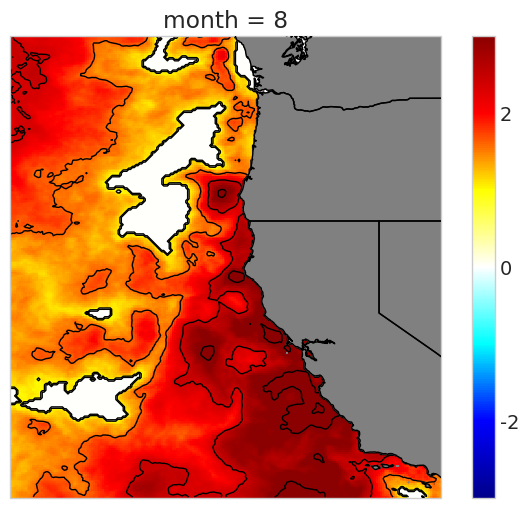

In [11]:
ax = plt.subplot(projection=crs)
anomaly_plot = anomalies_2015_white[7, :, :].plot(ax=ax,transform=crs,cmap=cmap_custom,add_colorbar=False,vmin=-3, vmax=3,zorder=1)
anomalies_2015_white[7, :, :].plot.contour(ax=ax, colors='black', linewidths=1)

cbar = plt.colorbar(anomaly_plot)
cbar.set_ticks([-2, 0, 2])
cbar.set_ticklabels([-2, 0, 2])
ax.add_feature(cfeature.STATES.with_scale("10m"),zorder=3)
ax.add_feature(cfeature.LAND, color="grey",zorder=2)

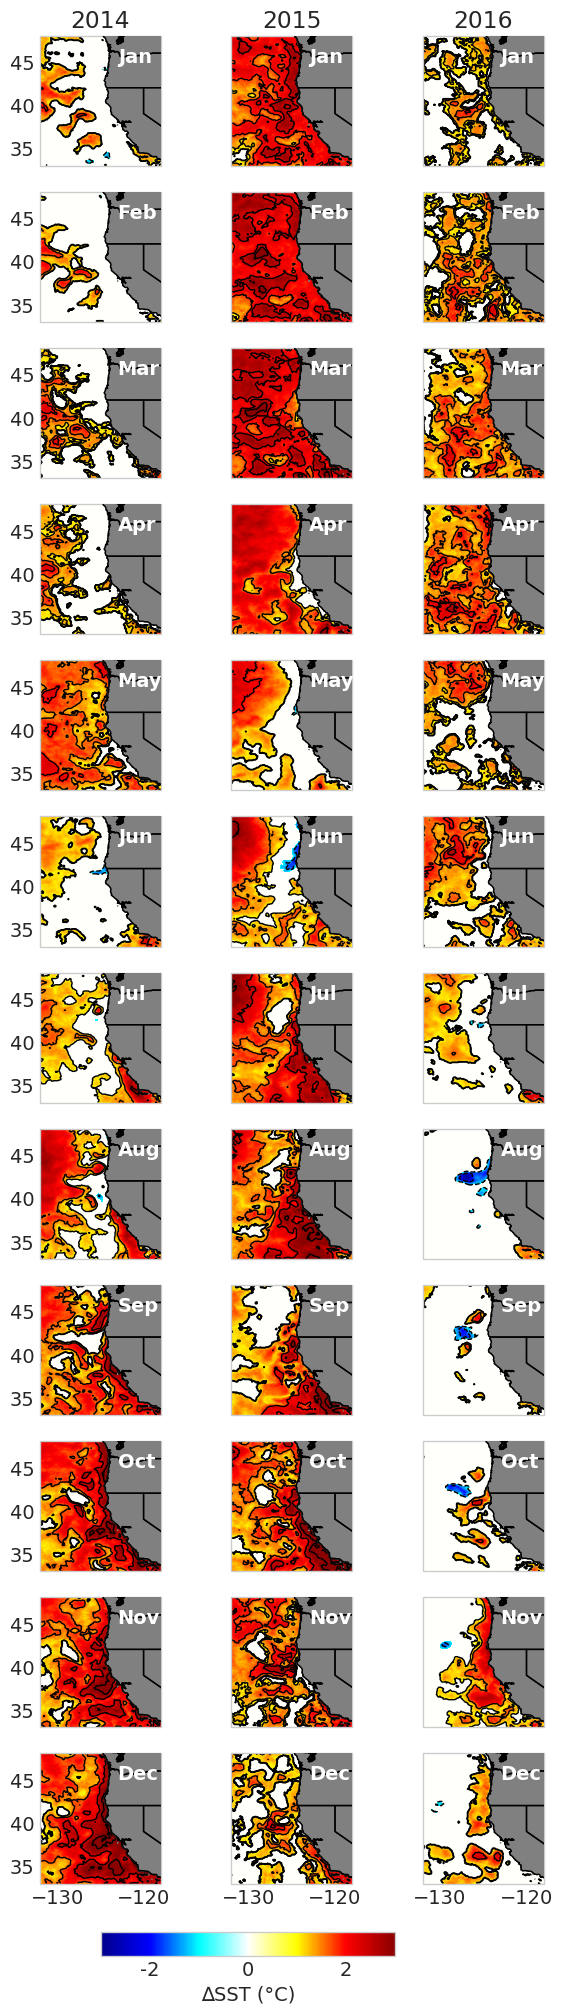

In [30]:
# Composing the entire plot for all months and years included
n_months=12
n_years=3
months = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
years = ["2014","2015","2016"]
fig, axs = plt.subplots(nrows=n_months, ncols=n_years, sharex=True, sharey=True, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(7,24))

# loop through the months and plots
for i in range(n_months):
    for j in range(n_years):    
        # Choose correct dataset to plot by per year
        if j == 0:
            # j = 0 corresponds to 2014
            anomalies = anomalies_2014_white
        if j == 1:
            # j = 0 corresponds to 2015
            anomalies = anomalies_2015_white
        if j == 2:
            # j = 0 corresponds to 2016
            anomalies = anomalies_2016_white
            
        # Plot the anomalies
        overall_plot = anomalies[i,:,:].plot(ax=axs[i, j], transform=crs, cmap=cmap_custom,add_colorbar=False,vmin=-3, vmax=3,zorder=1) 
        anomalies[i,:,:].plot.contour(ax=axs[i, j], colors='black', linewidths=1,zorder=2)
        axs[i,j].add_feature(cfeature.LAND, color="grey",zorder=3)
        axs[i,j].add_feature(cfeature.STATES.with_scale("10m"),zorder=4)
        # Remove default title
        axs[i,j].set_title("")
        # Remove default labels
        axs[i,j].set(xlabel=None, ylabel=None)
        # Plot month name
        axs[i,j].text(-123, 45, months[i], fontsize=14, color="white", fontweight="semibold",zorder=5)

        # Plot overall titles for the figure
        if i == 0:
            # First row add year
            axs[i,j].set_title(years[j])
        if j == 0:
            # Left col add yticks for lat
            axs[i,j].set_yticks([35, 40, 45])
        if i == 11:
            # Bottom row add xticks for long
            axs[i,j].set_xticks([-130, -120])

# Try to match paper's spacing
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots_adjust.html
# fig.subplots_adjust()

# Plotting legend
# Try to put the ax in the right place
ax = fig.add_axes([.24, .08, .42, .01])
# Plot the colorbar
cbar = plt.colorbar(overall_plot, cax=ax, orientation='horizontal')
cbar.set_label('∆SST (°C)', loc="center")
cbar.set_ticks([-2, 0, 2])
cbar.set_ticklabels([-2, 0, 2])

fig.show()